In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('NYCTaxiFares.csv')
df #here we're try to predict the fare_amount column 

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1
...,...,...,...,...,...,...,...,...
119995,2010-04-18 14:33:03 UTC,15.3,1,-73.955857,40.784590,-73.981941,40.736789,1
119996,2010-04-23 10:27:48 UTC,15.3,1,-73.996329,40.772727,-74.049890,40.740413,1
119997,2010-04-18 18:50:40 UTC,12.5,1,-73.988574,40.749772,-74.011541,40.707799,3
119998,2010-04-13 08:14:44 UTC,4.9,0,-74.004449,40.724529,-73.992697,40.730765,1


In [5]:
df['fare_amount'].describe() #looks like the largest value was $49.90 and the average price is $10.04

count    120000.000000
mean         10.040326
std           7.500134
min           2.500000
25%           5.700000
50%           7.700000
75%          11.300000
max          49.900000
Name: fare_amount, dtype: float64

# **Part 1**
Feature Engineering 1: Distance

In [6]:
#Below is the Haversine distance formula to calculate the distance travelled on a sphere. So in our case, we'd be using it to calculate distance between the pick up/drop off longitudes/latitudes on Earth
def Haversine(dataframe, pickup_lat, pickup_long, dropoff_lat, dropoff_long):
    r = 6371  #average radius in km of Earth
       
    phi1 = np.radians(df[pickup_lat]) #converting into radians
    phi2 = np.radians(df[dropoff_lat]) #converting into radians
    
    delta_phi = np.radians(df[dropoff_lat]-df[pickup_lat]) #converting into radians
    delta_lambda = np.radians(df[dropoff_long]-df[pickup_long]) #converting into radians
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2 #Haversine distance formula
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [7]:
df['dist_km'] = Haversine(df, 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude') #adding a new column to contain the distance calculated by the haversine function

In [8]:
#We just performed Feature Engineering
#Feature Engineering is taking the features we are already given and creating a new one that will be more useful for our model. In this case, we feature engineered the dist_km column using our latitude and longitude data
#The reason we created this dist_km column is because if we tried creating our model that took in just the longitude/latitude, that's a lot more data to process and the extra variables may result in poor results. In addition, the longitude/latitude data points are not too big of a difference from each other. As such, creating a new, distinct single feature (dist_km) could result in faster computation and better results.
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


Feature Engineering 2: Date-Time

In [9]:
df.info() #notice how pickup_datetime has Dtype = object, meaning it's treated like a string right now

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   pickup_datetime    120000 non-null  object 
 1   fare_amount        120000 non-null  float64
 2   fare_class         120000 non-null  int64  
 3   pickup_longitude   120000 non-null  float64
 4   pickup_latitude    120000 non-null  float64
 5   dropoff_longitude  120000 non-null  float64
 6   dropoff_latitude   120000 non-null  float64
 7   passenger_count    120000 non-null  int64  
 8   dist_km            120000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 8.2+ MB


In [10]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime']) #converting our pickup_datetime column into an actual date time rather than a string

In [11]:
df.info() #notice how it's a datetime object now

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   pickup_datetime    120000 non-null  datetime64[ns, UTC]
 1   fare_amount        120000 non-null  float64            
 2   fare_class         120000 non-null  int64              
 3   pickup_longitude   120000 non-null  float64            
 4   pickup_latitude    120000 non-null  float64            
 5   dropoff_longitude  120000 non-null  float64            
 6   dropoff_latitude   120000 non-null  float64            
 7   passenger_count    120000 non-null  int64              
 8   dist_km            120000 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(6), int64(2)
memory usage: 8.2 MB


In [13]:
df['EDTdate'] = df['pickup_datetime'] - pd.Timedelta(hours = 4) #converting our date time from UTC to EDT
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56+00:00
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53+00:00
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26+00:00
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03+00:00
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01+00:00


In [14]:
#so a neural network isn't going to understand what a date time object is when being fed into it. So we need to perform feature engineering to grab specific information from our date time object that can be fed into our NN.
#Now that we're converted our pickup_datetime into a datetime object, it can be broken up into components, such as hour, minute, day, etc
df['Hour'] = df['EDTdate'].dt.hour #making a new column to get the hour
df['AMorPM'] = np.where( df['Hour'] < 12, 'am', 'pm') #if hour is less than 12, then it's AM, else it's PM
df['Weekday'] = df['EDTdate'].dt.strftime("%a") #getting the date of the week. Can also use .dt.dayofweek
df.head() #So we feature engineered 3 more columns with specific information about the date time

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56+00:00,4,am,Mon
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53+00:00,11,am,Sat
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26+00:00,7,am,Sat
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03+00:00,17,pm,Sun
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01+00:00,22,pm,Fri


# **Part 2**
Separating Categorical Variables

In [17]:
categorical_col = ['Hour', 'AMorPM', 'Weekday'] #categorical columns
continuous_col = ['pickup_longitude','pickup_latitude', 'dropoff_longitude', 'dropoff_latitude','passenger_count', 'dist_km'] #continuous columns
y_col = ['fare_amount'] #this will be the answer that we want to be the output of our NN

In [18]:
df.dtypes #notice weekday and AMorPM are objects, but we want to convert them into categoires

pickup_datetime      datetime64[ns, UTC]
fare_amount                      float64
fare_class                         int64
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dist_km                          float64
EDTdate              datetime64[ns, UTC]
Hour                               int64
AMorPM                            object
Weekday                           object
dtype: object

In [19]:
for cat in categorical_col:
  df[cat] = df[cat].astype('category')

df.dtypes #notice they are categories now

pickup_datetime      datetime64[ns, UTC]
fare_amount                      float64
fare_class                         int64
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dist_km                          float64
EDTdate              datetime64[ns, UTC]
Hour                            category
AMorPM                          category
Weekday                         category
dtype: object

In [20]:
df['Weekday'].head() #notice the weekday column is has 7 categories
#similarly, AMorPM would have 2 categories, Hour would have 24 categories, etc

0    Mon
1    Sat
2    Sat
3    Sun
4    Fri
Name: Weekday, dtype: category
Categories (7, object): ['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed']

In [21]:
print(df['Weekday'].cat.codes.values) #so we're given a code for each day of the weekend from 0 to 6
print(df['AMorPM'].cat.codes.values) #so we're given a code for AM = 0, PM = 1

[1 2 2 ... 3 5 2]
[0 0 0 ... 1 0 1]


In [22]:
hr = df['Hour'].cat.codes.values #extracting the code for each hour
ampm = df['AMorPM'].cat.codes.values  #extracting the code for AM and PM
wkdy = df['Weekday'].cat.codes.values  #extracting the code for each day of the week

cats = np.stack([hr, ampm, wkdy], axis = 1) #so we're stacking the arrays together along the y-axis to make a row for each
cats #first entry is 4 AM on Monday

#could've done this all in one line using:
#cats = np.stack([df[col].cat.codes.values for col in categorical_col], 1)

array([[ 4,  0,  1],
       [11,  0,  2],
       [ 7,  0,  2],
       ...,
       [14,  1,  3],
       [ 4,  0,  5],
       [12,  1,  2]], dtype=int8)

In [23]:
cats = torch.tensor(cats, dtype = torch.int64) #converting our categories into a PyTorch Tensor to feed into our model

Separating Continuous Variables

In [24]:
conts = np.stack([df[col].values for col in cont_cols], axis = 1) #doing what we did above to categorical values, except in one line for continuous
conts 

array([[-73.992365  ,  40.730521  , -73.975499  ,  40.744746  ,
          1.        ,   2.12631159],
       [-73.990078  ,  40.740558  , -73.974232  ,  40.744114  ,
          1.        ,   1.39230687],
       [-73.994149  ,  40.751118  , -73.960064  ,  40.766235  ,
          2.        ,   3.32676344],
       ...,
       [-73.988574  ,  40.749772  , -74.011541  ,  40.707799  ,
          3.        ,   5.05252282],
       [-74.004449  ,  40.724529  , -73.992697  ,  40.730765  ,
          1.        ,   1.20892296],
       [-73.955415  ,  40.77192   , -73.967623  ,  40.763015  ,
          3.        ,   1.42739869]])

In [25]:
conts = torch.tensor(conts, dtype=torch.float) #converting our continous variables into a PyTorch Tensor
conts

tensor([[-73.9924,  40.7305, -73.9755,  40.7447,   1.0000,   2.1263],
        [-73.9901,  40.7406, -73.9742,  40.7441,   1.0000,   1.3923],
        [-73.9941,  40.7511, -73.9601,  40.7662,   2.0000,   3.3268],
        ...,
        [-73.9886,  40.7498, -74.0115,  40.7078,   3.0000,   5.0525],
        [-74.0044,  40.7245, -73.9927,  40.7308,   1.0000,   1.2089],
        [-73.9554,  40.7719, -73.9676,  40.7630,   3.0000,   1.4274]])

Separating The Label (Answer)

In [26]:
y = torch.tensor(df[y_col].values, dtype=torch.float)
y

tensor([[ 6.5000],
        [ 6.9000],
        [10.1000],
        ...,
        [12.5000],
        [ 4.9000],
        [ 5.3000]])

In [28]:
print('cats.shape =',cats.shape)
print('conts.shape =',conts.shape)
print('y.shape =',y.shape)
#shapes are as expected with 3 columns in categorical, 6 columns in continuous, and 1 column as the label

cats.shape = torch.Size([120000, 3])
conts.shape = torch.Size([120000, 6])
y.shape = torch.Size([120000, 1])


Embedding our Categories (One Hot Encoding)

In [29]:
categorical_sizes = [len(df[col].cat.categories) for col in categorical_col] #category sizes

categorical_sizes #shows how many categories we have in each column, so our case is 24 hours in a day, 2 (AM or PM), and 7 days in a week

[24, 2, 7]

In [30]:
emb_sizes = [(size, min(50, (size+1)//2)) for size in categorical_sizes] #so for size (24 ,2 ,7) in cat_szs, embed 50 or take the size and divide by 2
#the +1 is incase we only have 2 categories and // is to make sure the output is an integer
emb_sizes #none of the sizes exceeded 50, so it just made the embedding size the size divided by 2. 
#so here, our number of categories are 24, 2, 7 and our embedding sizes are 12, 1, 4

#So the embedding provides a more compact (lower dimensional) representation of a set of input variables that have some correlations. It's useful because it reduces the number of parameters overall. 
#So technically we could've just used all 24 hours + 2 am or pm + 7 days of the week as inputs into our NN, but we used embedding to reduce the parameters and make calculations faster
#An embedding layer simply maps/projects some N dimensional tensor into another number of dimensions, the number of dimensions to output to are often arbitrary, but you can have some logic to it, like embedding 7 days a week to 2 dimensions may end up mapping closely to weekday vs weekends (although there is no guarantee of this)

[(24, 12), (2, 1), (7, 4)]

# **Part 3**

Creating the Model

In [43]:
#Inheriting from nn.Module to use it's features
class Model(nn.Module):
  def __init__(self, emb_sizes, n_continuous, out_size, n_layers, p=0.5):
    #so our parameters are embedding size, number of continous features, output size, number of layers, and our dropout probability defaulted to 50%
    #This determins how many layers are there in our NN
    #Input Layer (4 features from Iris dataset)--> Hidden Layer 1 --> Hidden Later 2 --> Output (3 classes)

    super().__init__() #inheriting the features from nn.Module
    self.embeds = nn.ModuleList([nn.Embedding(num_embeddings = ni, embedding_dim = nf) for ni,nf in emb_sizes]) #so now our ModuleList is filled with the Embedding layers (one for hour, one of ampm, and one for weekday)
    self.emb_drop = nn.Dropout(p) #adding a dropout layer
    self.bn_cont = nn.BatchNorm1d(n_continuous) #normalizing the continous data so it falls within the same order of magnitude range

    layerlist = [] #initializing layerlist so we can store our layers
    n_emb = sum([nf for ni,nf in emb_sizes]) #calculating the number of embeddings, which is basically 12 + 1 + 4
    n_in = n_emb + n_continuous #so the total number of inputs will be the number of embeddings plus the number of continous features

    for i in n_layers:
      layerlist.append(nn.Linear(n_in, i)) #create a layer connecting n_in and i, where i is the number of neurons. Basically this makes a fully connected layer. 
      layerlist.append(nn.ReLU(inplace = True)) #adding the activation function to the layer
      layerlist.append(nn.BatchNorm1d(i)) #adding the normalization of the continuous values to the list
      layerlist.append(nn.Dropout(p)) #adding the dropout to the layer
      n_in = i #equating n_in with the number of neurons i, so that the next fully connected layer can start with i - 1 neurons.

    #So layers is going to look like this: layers = [256, 128, 64] meaning you want 256 neurons in first layer, then 128 neurons in second layer, then 64. This allows us play around with the values and makes it flexible. 
    layerlist.append(nn.Linear(n_layers[-1], out_size)) #so making the last layer be connected by the last layer and output size
    self.layers = nn.Sequential(*layerlist) #using sequential to combine the layers from the layerlist so that it can be ordered properly as a NN

  def forward(self, x_categorical, x_continuous):
    #So this determines the forward propagation with the activation functions we want to use

    # Now we are utilizing the embeddings to pass into our forward method
    embeddings = [] 

    for i,e in enumerate(self.embeds):
      embeddings.append(e(x_categorical[:,i])) #so we're adding to our embeddingz list for each row and column i in our categorical inputs, x_cat

    x = torch.cat(tensors = embeddings, dim = 1) #so we're concatenating embeddings along dimension 1, meaning all the values we got above for each tensor will be within a single row (i.e. 12(hour) + 1(amorpm) + 4(weekday) all in one row within a single tensor)
    x = self.emb_drop(x) #adding the drop out layer to our embedded categorical data

    x_cont = self.bn_cont(x_continuous) #normalizing our continuous data
    x = torch.cat(tensors = [x, x_continuous], dim = 1) #concatenating our categorical and continuous data to be in a single tensor row
    x = self.layers(x) #passing our continuous and categorical data into our NN, which was made above with Sequential

    return x

# **Part 4**

In [44]:
model = Model(emb_sizes,  n_continuous = conts.shape[1], out_size = 1, n_layers = [256, 128, 64], p=0.5) #conts.shape[1] is the number of columns in the continuous tensor, output size is 1, and hidden layers will have 200 then 100 neurons
model

Model(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.5, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [45]:
criterion = nn.MSELoss() #will convert this later to RMS so that our units are squared

optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.001) #model parameters are just the fully connected layers and we are using Adam optimizer to optimize them
model.parameters #can see the parameters are just the fully connected layers and we are optimizing them

<bound method Module.parameters of Model(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.5, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=64, out_

In [46]:
batch_size = 120000 #just going to feed in all the data
test_size = int(batch_size*0.25) #making our test size 1/3 the batch size

In [47]:
#Our data was shuffled already when we got it, which is why we can do the following. If it wasn't shuffled already, then we'd need to shuffle first before assigning the train test split

categorical_train = cats[:batch_size - test_size] #so take from index 0 to 24000
categorical_test = cats[batch_size - test_size: batch_size] #take from index 24000 to 30000
continuous_train = conts[:batch_size - test_size]
continuous_test = conts[batch_size - test_size: batch_size]
y_train = y[:batch_size - test_size]
y_test = y[batch_size - test_size: batch_size]

print(len(categorical_train))
print(len(categorical_test))
print(len(continuous_train))
print(len(continuous_test))
print(len(y_train))
print(len(y_test))

90000
30000
90000
30000
90000
30000


In [48]:
import time #Gonna try to keep track of how long it takes to train our model

start_time = time.time()

epochs = 450

losses = []

#This for loop trains our NN
for i in range(epochs):
  #Forward propagation through our ANN using training data
  y_pred = model.forward(categorical_train, continuous_train)

  #Calculating loss/error
  loss = torch.sqrt(criterion(y_pred, y_train)) #turning our MSE into RMSE so our units don't get squared
  losses.append(loss)

  print(f'epoch {i} and loss is: {loss} and time: {(time.time() - start_time)/60}')

  #Backpropagation
  optimizer.zero_grad() #resetting the gradient on the optimizer so it doesn't accumulate
  loss.backward() #doing backpropagation off the loss function
  optimizer.step() #using the optimizer for the back propagation

print(f'Training took {(time.time() - start_time)/60} minutes')

epoch 0 and loss is: 12.438814163208008 and time: 0.03742837905883789
epoch 1 and loss is: 12.27503490447998 and time: 0.13643746376037597
epoch 2 and loss is: 12.119855880737305 and time: 0.23397483030954996
epoch 3 and loss is: 11.99235725402832 and time: 0.33265262842178345
epoch 4 and loss is: 11.879670143127441 and time: 0.4311389724413554
epoch 5 and loss is: 11.780956268310547 and time: 0.5300045291582743
epoch 6 and loss is: 11.684331893920898 and time: 0.6268419067064921
epoch 7 and loss is: 11.60068416595459 and time: 0.7245704849561055
epoch 8 and loss is: 11.532145500183105 and time: 0.8214169383049011
epoch 9 and loss is: 11.467344284057617 and time: 0.9189644614855449
epoch 10 and loss is: 11.403987884521484 and time: 1.0166694362958273
epoch 11 and loss is: 11.357162475585938 and time: 1.1139453967412314
epoch 12 and loss is: 11.299732208251953 and time: 1.211779816945394
epoch 13 and loss is: 11.25107479095459 and time: 1.3086176911989849
epoch 14 and loss is: 11.219152

Text(0.5, 0, 'Epoch')

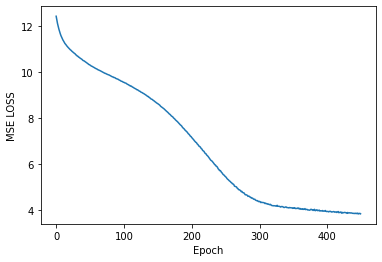

In [49]:
#Plotting our error
plt.plot(range(epochs),losses)
plt.ylabel('MSE LOSS')
plt.xlabel('Epoch') 

In [50]:
#This just turns off the backpropagation, so we can use the model for evaluation rather than training. This helps reduce memory usage and computation speed
with torch.no_grad():
  y_eval = model.forward(categorical_test, continuous_test)
  loss = torch.sqrt(criterion(y_eval, y_test)) #comparing the actual results with the evaluation results

print('loss =',loss) #average rmse

loss = tensor(3.8764)


In [51]:
for i in range(30):
  diff = np.abs(y_eval[i].item() - y_test[i].item())
  print(f'{i}.) PREDICTED {y_eval[i].item():8.2f}   TRUE: {y_test[i].item():8.2f}   DIFF: {diff:8.2f}')

0.) PREDICTED     7.36   TRUE:     7.70   DIFF:     0.34
1.) PREDICTED    16.36   TRUE:    12.90   DIFF:     3.46
2.) PREDICTED    13.20   TRUE:    14.90   DIFF:     1.70
3.) PREDICTED     3.13   TRUE:     5.70   DIFF:     2.57
4.) PREDICTED     9.01   TRUE:     8.50   DIFF:     0.51
5.) PREDICTED     6.51   TRUE:    11.70   DIFF:     5.19
6.) PREDICTED     6.83   TRUE:     5.30   DIFF:     1.53
7.) PREDICTED     5.31   TRUE:     6.50   DIFF:     1.19
8.) PREDICTED    11.47   TRUE:    22.10   DIFF:    10.63
9.) PREDICTED     7.99   TRUE:     5.30   DIFF:     2.69
10.) PREDICTED     3.90   TRUE:     6.90   DIFF:     3.00
11.) PREDICTED     7.00   TRUE:     6.50   DIFF:     0.50
12.) PREDICTED     9.56   TRUE:     8.10   DIFF:     1.46
13.) PREDICTED    25.23   TRUE:    33.87   DIFF:     8.64
14.) PREDICTED     4.60   TRUE:     5.70   DIFF:     1.10
15.) PREDICTED    26.60   TRUE:    28.50   DIFF:     1.90
16.) PREDICTED     8.13   TRUE:    25.07   DIFF:    16.94
17.) PREDICTED     8.97 

In [59]:
torch.save(model.state_dict(), 'taxifare_model.pt') #saving the model